In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end])
    plt.plot(series[start:end])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return time*slope
    
def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 152ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 12ms/step - loss: 27.6651 - mae: 28.1627
Epoch 88/100
8/8 [==============================] - 0s 13ms/step - loss: 28.1057 - mae: 28.6024
Epoch 89/100
8/8 [==============================] - 0s 9ms/step - loss: 25.0099 - mae: 25.5036
Epoch 90/100
8/8 [==============================] - 0s 12ms/step - loss: 29.2331 - mae: 29.7304
Epoch 91/100
8/8 [==============================] - 0s 8ms/step - loss: 39.5661 - mae: 40.0657
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 20.2192 - mae: 20.7125
Epoch 93/100
8/8 [==============================] - 0s 14ms/step - loss: 42.4172 - mae: 42.9140
Epoch 94/100
8/8 [==============================] - 0s 9ms/step - loss: 46.5167 - mae: 47.0166
Epoch 95/100
8/8 [==============================] - 0s 14ms/step - loss: 50.0829 - mae: 50.5817
Epoch 96/100
8/8 [==============================] - 0s 16ms/step - loss: 57.1794 - mae: 57.6787
Epoch 97/100
8/8 [==============================] - 0s 18

(1e-08, 0.0001, 0.0, 30.0)

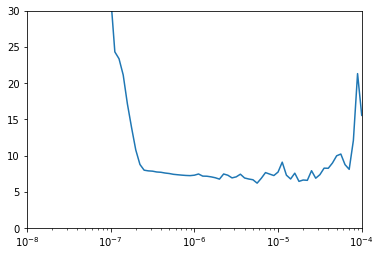

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 18ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 13ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 15ms/step - loss: 15.9199 - mae: 16.4142
Epoch 4/400
8/8 [==============================] - 0s 13ms/step - loss: 12.2877 - mae: 12.7812
Epoch 5/400
8/8 [==============================] - 0s 18ms/step - loss: 10.1472 - mae: 10.6373
Epoch 6/400
8/8 [==============================] - 0s 23ms/step - loss: 16.6924 - mae: 17.1866
Epoch 7/400
8/8 [==============================] - 0s 22ms/step - loss: 13.1498 - mae: 13.6422
Epoch 8/400
8/8 [==============================] - 0s 22ms/step - loss: 10.2348 - mae: 10.7232
Epoch 9/400
8/8 [==============================] - 0s 22ms/step - loss: 11.1116 - mae: 11.6020
Epoch 10/400
8/8 [==============================] - 0s 18ms/step - loss: 14.1436 - mae: 14.6385
Epoch 11/400
8/8 [==============================]

8/8 [==============================] - 0s 13ms/step - loss: 7.0112 - mae: 7.4921
Epoch 88/400
8/8 [==============================] - 0s 12ms/step - loss: 5.0334 - mae: 5.5168
Epoch 89/400
8/8 [==============================] - 0s 13ms/step - loss: 5.9630 - mae: 6.4488
Epoch 90/400
8/8 [==============================] - 0s 13ms/step - loss: 6.3576 - mae: 6.8407
Epoch 91/400
8/8 [==============================] - 0s 12ms/step - loss: 5.0321 - mae: 5.5107
Epoch 92/400
8/8 [==============================] - 0s 15ms/step - loss: 4.8178 - mae: 5.2972
Epoch 93/400
8/8 [==============================] - 0s 13ms/step - loss: 4.5613 - mae: 5.0355
Epoch 94/400
8/8 [==============================] - 0s 12ms/step - loss: 5.2251 - mae: 5.7064
Epoch 95/400
8/8 [==============================] - 0s 13ms/step - loss: 4.9745 - mae: 5.4584
Epoch 96/400
8/8 [==============================] - 0s 13ms/step - loss: 5.2277 - mae: 5.7073
Epoch 97/400
8/8 [==============================] - 0s 12ms/step - loss: 

8/8 [==============================] - 0s 13ms/step - loss: 8.0281 - mae: 8.5185
Epoch 174/400
8/8 [==============================] - 0s 15ms/step - loss: 8.3128 - mae: 8.8009
Epoch 175/400
8/8 [==============================] - 0s 13ms/step - loss: 6.4605 - mae: 6.9455
Epoch 176/400
8/8 [==============================] - 0s 13ms/step - loss: 4.9604 - mae: 5.4387
Epoch 177/400
8/8 [==============================] - 0s 12ms/step - loss: 4.7413 - mae: 5.2190
Epoch 178/400
8/8 [==============================] - 0s 15ms/step - loss: 5.6941 - mae: 6.1777
Epoch 179/400
8/8 [==============================] - 0s 12ms/step - loss: 4.6720 - mae: 5.1545
Epoch 180/400
8/8 [==============================] - 0s 13ms/step - loss: 4.2514 - mae: 4.7259
Epoch 181/400
8/8 [==============================] - 0s 12ms/step - loss: 4.9201 - mae: 5.3984
Epoch 182/400
8/8 [==============================] - 0s 13ms/step - loss: 4.4062 - mae: 4.8859
Epoch 183/400
8/8 [==============================] - 0s 13ms/ste

8/8 [==============================] - 0s 13ms/step - loss: 4.6815 - mae: 5.1541
Epoch 260/400
8/8 [==============================] - 0s 13ms/step - loss: 5.0215 - mae: 5.5013
Epoch 261/400
8/8 [==============================] - 0s 15ms/step - loss: 5.6149 - mae: 6.0979
Epoch 262/400
8/8 [==============================] - 0s 13ms/step - loss: 5.1192 - mae: 5.5995
Epoch 263/400
8/8 [==============================] - 0s 14ms/step - loss: 4.9342 - mae: 5.4103
Epoch 264/400
8/8 [==============================] - 0s 13ms/step - loss: 4.5354 - mae: 5.0109
Epoch 265/400
8/8 [==============================] - 0s 17ms/step - loss: 4.9795 - mae: 5.4595
Epoch 266/400
8/8 [==============================] - 0s 13ms/step - loss: 4.3873 - mae: 4.8602
Epoch 267/400
8/8 [==============================] - 0s 16ms/step - loss: 4.3816 - mae: 4.8618
Epoch 268/400
8/8 [==============================] - 0s 13ms/step - loss: 4.4946 - mae: 4.9697
Epoch 269/400
8/8 [==============================] - 0s 13ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 4.6974 - mae: 5.1768
Epoch 346/400
8/8 [==============================] - 0s 13ms/step - loss: 4.7254 - mae: 5.2054
Epoch 347/400
8/8 [==============================] - 0s 12ms/step - loss: 6.3734 - mae: 6.8613
Epoch 348/400
8/8 [==============================] - 0s 12ms/step - loss: 5.4327 - mae: 5.9155
Epoch 349/400
8/8 [==============================] - 0s 14ms/step - loss: 5.1935 - mae: 5.6762
Epoch 350/400
8/8 [==============================] - 0s 12ms/step - loss: 4.7071 - mae: 5.1882
Epoch 351/400
8/8 [==============================] - 0s 12ms/step - loss: 6.0705 - mae: 6.5516
Epoch 352/400
8/8 [==============================] - 0s 13ms/step - loss: 6.2047 - mae: 6.6886
Epoch 353/400
8/8 [==============================] - 0s 12ms/step - loss: 6.7252 - mae: 7.2139
Epoch 354/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5498 - mae: 5.0263
Epoch 355/400
8/8 [==============================] - 0s 8ms/step

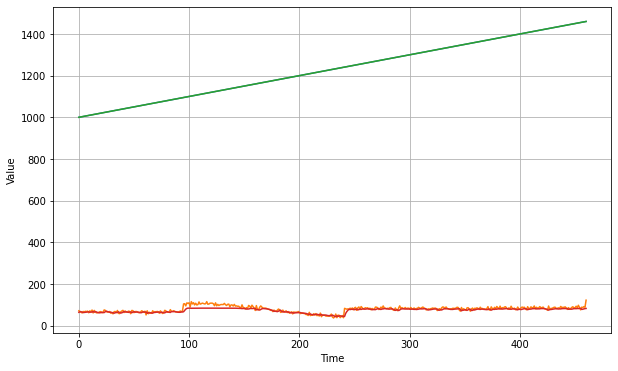

In [7]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.9596496

<Figure size 432x288 with 0 Axes>

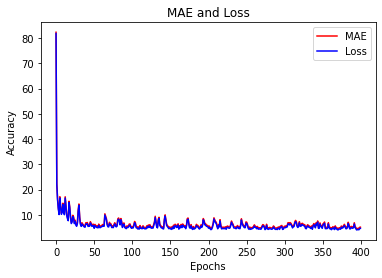

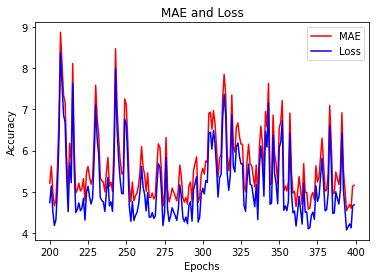

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()